# ACNets: Diagonal Connectivity Classifier

This notebook fits a binary classifier to predict participant's group, AVGP or NVGP, using functional connectivity matrices. As input, it takes upper-triangular connectivity matrices for each participant.

To address the concerns about small sample size and test/train splits, results are evaluated using 5-fold cross-validated permutation testing.

## 0. Setup

In [175]:

import math
import re

import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('notebook')

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection, dummy, svm

from sklearn.pipeline import Pipeline

import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from python.acnets.datasets import load_connectivity


from tqdm import tqdm


# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

%reload_ext autoreload
%autoreload 3

Last updated: 2022-02-23T17:19:20.977621+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
sklearn   : 1.0.2
xarray    : 0.21.1
skopt     : 0.9.0
matplotlib: 3.5.1
seaborn   : 0.11.2
re        : 2.2.1
numpy     : 1.21.5
nilearn   : 0.9.0
pandas    : 1.4.0



# Fit the model

In [176]:
atlas = 'dosenbach2007'
connectivity_measure = 'tangent'

In [181]:
cv = model_selection.StratifiedKFold(5)

pipe = Pipeline([
  ('zv', feature_selection.VarianceThreshold()),
  # ('fa', decomposition.FactorAnalysis()),
  ('clf', svm.SVC(kernel='linear', probability=False))
])

param_space = {
  # 'fa__rotation': Categorical(['varimax']),
  # 'fa__n_components': Categorical([6]), # Integer(1, 10),
  'clf__C': Real(1e-3, 1e3, 'log-uniform'),
}

opt = BayesSearchCV(pipe, param_space, cv=cv, n_jobs=1, scoring='roc_auc')

def fit(X, y, feature_names):
  # encode y as integers
  y_encoder = preprocessing.LabelEncoder()
  y = y_encoder.fit_transform(y)
      
  # test/train splits
  train, test = model_selection.train_test_split(
    range(len(X)),
    test_size=0.2,
    shuffle=True,
    stratify=y,)
      
  progress_bar = tqdm(total=opt.total_iterations)

  opt.fit(X[train], y[train],
          callback = [
            skopt.callbacks.DeadlineStopper(total_time=300),
            lambda _: False if progress_bar.update() else False,
  ])

  progress_bar.close()
  
  # evaluate
  score_train = opt.score(X[train], y[train])
  score_test = opt.score(X[test], y[test])

  # report scores and hyperparameters
  print(f'train set score (roc_auc): {score_train:.2f}')
  print(f'test set score (roc_auc): {score_test:.2f}')

  # we don't have a hyperparameter so we pass 'pipe' instead of 'grid'
  obs_score, perm_scores, p_value = model_selection.permutation_test_score(
    opt.best_estimator_, X, y,
    cv=cv,
    scoring='roc_auc',
    n_permutations=100,
    n_jobs=-1, verbose=0)
  
  print('obs_score,perm_scores_mean,p_value:', obs_score, perm_scores.mean(), p_value)
  
def preprocess(X, y, feature_names):
  # binarize
  X_threshold = np.array([np.median(x, keepdims=True) + x.std(keepdims=True) for x in X])
  X = np.where(np.abs(X) > X_threshold, 1, 0)

  if len(X.shape) == 3:
    X = np.array([x[np.triu_indices_from(x, k=1)] for x in X])
    feature_names = feature_names.values[np.triu_indices_from(feature_names.values, k=1)]

  # remove zero-variance features
  zv_mask = (X.std(axis=0) == 0)
  X = X[:,~zv_mask]
  feature_names = feature_names[~zv_mask]
  return X, y, feature_names


X, y, feature_names = load_connectivity(
  parcellation=atlas,
  kind=connectivity_measure,
  vectorize=False,
  return_y=True,
  only_diagonal=True,
  return_feature_names=True,
  discard_diagonal=False,
  discard_cerebellum=False,)

# fit the FA model
# fit(X, y, feature_names)
# fa_components = opt.best_estimator_.named_steps['fa'].components_.T

Extract network names from the atlas:

In [182]:
from nilearn import datasets as nilean_datasets

if atlas == 'dosenbach2010':
  atlas = nilean_datasets.fetch_coords_dosenbach_2010(legacy_format=False)
  labels = pd.concat(
    [pd.DataFrame(v) for k, v in atlas.items() if k != 'description'], axis=1)
  labels.set_index(0, inplace=True)
  feature_network_names = labels.loc[feature_names.tolist(), 'network']

elif atlas == 'dosenbach2007':
  dosenbach2007_networks = [
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3,
    4, 4,
    5, 5, 5, 5,
    6, 6, 6, 6, 6, 6, 6, 6,
    7, 7,
    8]
  feature_network_names = pd.Series(dosenbach2007_networks, index=feature_names.tolist())


In [218]:

factors = dict.fromkeys([f'network_{net}' for net in feature_network_names.unique()], [])

for feat, net in feature_network_names.iteritems():
  factors[f'network_{net}'] = factors[f'network_{net}'] + [feat]


from factor_analyzer import ConfirmatoryFactorAnalyzer, ModelSpecificationParser

factors_spec = ModelSpecificationParser.parse_model_specification_from_dict(
  X,
  factors)

cfa = ConfirmatoryFactorAnalyzer(factors_spec, disp=False) 

X_norm = preprocessing.StandardScaler().fit_transform(X)
X_cfa = cfa.fit_transform(X_norm)

# test/train splits
train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.2,
  shuffle=True,
  stratify=y,)

opt.fit(X_cfa[train], y[train])
opt.score(X_cfa[test], y[test])

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:732: UserWarning: The optimization routine failed to converge: ABNORMAL_TERMINATION_IN_LNSRCH
  warnings.warn('The optimization routine failed '
/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/Caskroom/miniforge/base/envs/acnet

0.8333333333333334

In [219]:
cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

obs_score, rnd_scores, p_value = model_selection.permutation_test_score(
  opt.best_estimator_,
  X_cfa, y,
  cv=cv,
  n_permutations=100,
  scoring='roc_auc')



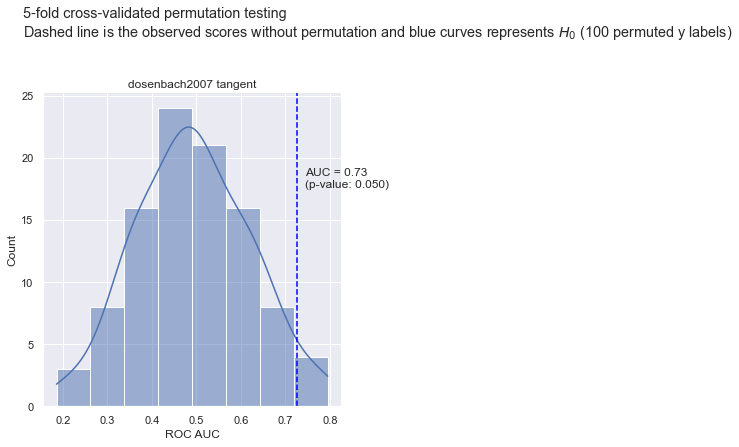

In [226]:

g = sns.displot(rnd_scores, kde=True)
# plt.vlines(obs_score, linestyles='dashed', linewidth=1)

plt.axvline(obs_score, ls='--', color='blue')

g.set(xlabel='ROC AUC')
plt.text(x=obs_score + .02,
        y=plt.gca().get_ylim()[1] * .7,
        s=f'AUC = {obs_score:.2f}\n(p-value: {p_value:.3f})')

g.ax.set_title(f'{atlas} {connectivity_measure}')
plt.suptitle('5-fold cross-validated permutation testing\n'
            'Dashed line is the observed scores without permutation '
            f'and blue curves represents $H_0$ ({100} permuted y labels)',
            y=1.2, x=.08, ha='left')
plt.show()

Assign colors to the networks and their corresponding regions:

In [227]:
palt = dict(zip(
  feature_network_names.unique(),
  sns.color_palette('Set1', feature_network_names.nunique())))

feature_network_colors = feature_network_names.apply(
  lambda x: pd.Series((palt[x], x)))
feature_network_colors.rename(columns={0:'color', 1:'network'}, inplace=True)
feature_network_colors.index.name = 'region'

Now plot the Factor Analysis components:

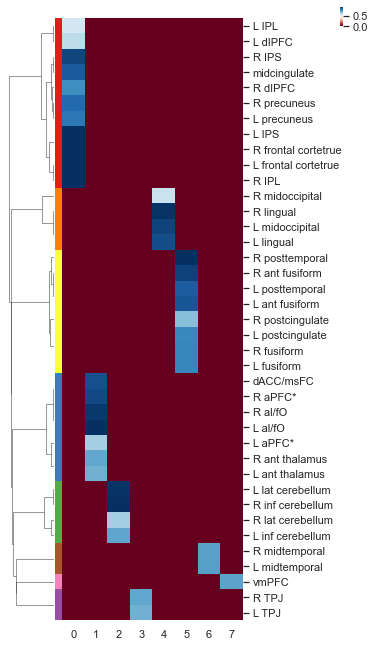

In [228]:
fa_comps = pd.DataFrame(
  cfa.loadings_,
  index=feature_names
)

sns.clustermap(fa_comps, figsize=(5,9),
               col_cluster=False,
               robust=True,
               dendrogram_ratio=(0.2, 0.000001),
               cbar_pos=(.96, .967, 0.01, 0.03),
               cmap='RdBu',
               row_colors=feature_network_colors['color'].tolist())


In [229]:
network_info = pd.DataFrame(feature_names[cfa.loadings_.argsort(axis=0)[::-1]],
             columns=[f'network_{i}' for i in range(cfa.loadings_.shape[1])])
network_info

,network_0,network_1,network_2,network_3,network_4,network_5,network_6,network_7
0,L IPS,L al/fO,R inf cerebellum,R TPJ,R lingual,R posttemporal,L midtemporal,vmPFC
1,R frontal cortetrue,R al/fO,L lat cerebellum,L TPJ,L midoccipital,R ant fusiform,R midtemporal,R dIPFC
2,L frontal cortetrue,R aPFC*,L inf cerebellum,vmPFC,L lingual,L ant fusiform,R dIPFC,R ant thalamus
3,R IPL,dACC/msFC,R lat cerebellum,L ant thalamus,R midoccipital,L posttemporal,R ant thalamus,L aPFC*
4,R IPS,R ant thalamus,L frontal cortetrue,L aPFC*,vmPFC,L fusiform,L aPFC*,R aPFC*
5,midcingulate,L ant thalamus,L al/fO,R aPFC*,R aPFC*,R fusiform,R aPFC*,dACC/msFC
6,R precuneus,L aPFC*,R ant thalamus,dACC/msFC,dACC/msFC,L postcingulate,dACC/msFC,L al/fO
7,L precuneus,R dIPFC,L IPS,L al/fO,L al/fO,R postcingulate,L al/fO,R al/fO
8,R dIPFC,L dIPFC,R frontal cortetrue,R al/fO,R al/fO,vmPFC,R al/fO,L dIPFC
9,L dIPFC,vmPFC,L aPFC*,L dIPFC,L dIPFC,R IPL,L dIPFC,L IPL


In [230]:
for i, network_coef in enumerate(opt.best_estimator_['clf'].coef_[0]):
  top_nodes = network_info.iloc[:4, i].to_list()
  print(f'network_{i}:\n'
        f'\tclassification coef: {network_coef:.2f}\n'
        f'\ttop nodes: {", ".join(top_nodes)}')


network_0:
	classification coef: -0.01
	top nodes: L IPS, R frontal cortetrue, L frontal cortetrue, R IPL
network_1:
	classification coef: -0.06
	top nodes: L al/fO, R al/fO, R aPFC*, dACC/msFC
network_2:
	classification coef: -0.04
	top nodes: R inf cerebellum, L lat cerebellum, L inf cerebellum, R lat cerebellum
network_3:
	classification coef: -0.04
	top nodes: R TPJ, L TPJ, vmPFC, L ant thalamus
network_4:
	classification coef: -0.11
	top nodes: R lingual, L midoccipital, L lingual, R midoccipital
network_5:
	classification coef: -0.05
	top nodes: R posttemporal, R ant fusiform, L ant fusiform, L posttemporal
network_6:
	classification coef: -0.07
	top nodes: L midtemporal, R midtemporal, R dIPFC, R ant thalamus
network_7:
	classification coef: 0.02
	top nodes: vmPFC, R dIPFC, R ant thalamus, L aPFC*


## FIXME: Permutation Importance

In [ ]:
%%script echo skipping

from sklearn.inspection import permutation_importance

pipe.fit(X, y)
perm_imp_result = permutation_importance(pipe, X, y, 
                                         n_repeats=100,
                                         scoring='roc_auc', n_jobs=-1)

perm_sorted_idx = perm_imp_result.importances_mean.argsort()

# sns.boxplot(
#     result.importances[perm_sorted_idx].T,
#     vert=False,
#     labels=data.feature_names[perm_sorted_idx],
# )


perm_imp_result.importances[perm_sorted_idx]

In [ ]:
%%script echo skipping

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 10))

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=feature_names.tolist(), ax=ax1, leaf_rotation=90
)

dendro_idx = np.arange(0, len(dendro["ivl"]))



ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [ ]:
%%script echo skipping

from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_clustered = X[:, selected_features]

# Permmutation Importance

from sklearn.inspection import permutation_importance

grid.fit(X_clustered[train], y[train])
perm_imp_result = permutation_importance(grid, X_clustered[test], y[test],
                                         scoring='roc_auc',
                                         n_repeats=100)

sorted_idx = perm_imp_result.importances_mean.argsort()[::-1][:10][::-1]

fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(
    perm_imp_result.importances[sorted_idx].T,
    labels = feature_names[np.array(selected_features)[sorted_idx]],
    vert=False,
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()